In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy import signal as sp_signal
from tqdm import tqdm

from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet

# plt.rcParams["figure.figsize"] = (15,5)

In [2]:
srate = 1024
npnts = srate * 5
time = np.arange(npnts)/srate

In [3]:
freqs = np.array([5, 10, 15, 20])
amps = np.array([9, 1, 5, 3])
signal = np.zeros(npnts)

for i in range(len(freqs)):
    signal += amps[i]*np.sin(2*np.pi*freqs[i]*time) + np.random.normal(scale=0.5, size=npnts)

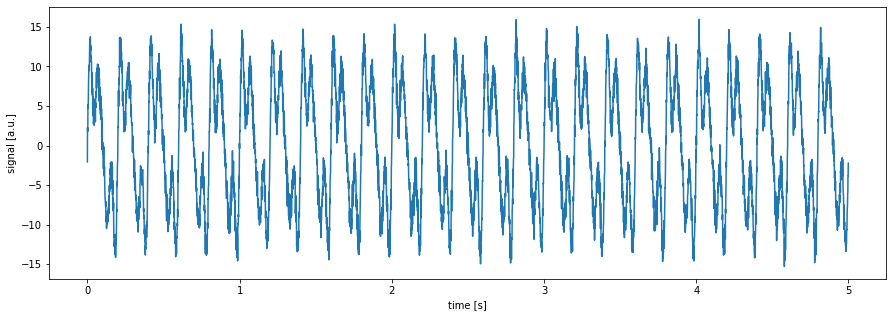

In [4]:
plt.figure(figsize=(15,5))
plt.plot(time, signal)
plt.xlabel('time [s]')
plt.ylabel('signal [a.u.]')
plt.show()

## Morlet Wavelet

### Using FWHM

In [ ]:
# wavelet parameters
wavtime = np.arange(-2, 2, 1/srate) # wavelet time
wav_frex = np.linspace(1, 30, 20) # frequencies to extract
fwhms = np.linspace(.5, .5, 20) 

halfwave = int(round((len(wavtime)-1)/2))

In [6]:
n_conv = npnts + len(wavtime) - 1
hz = np.linspace(0, srate, n_conv)

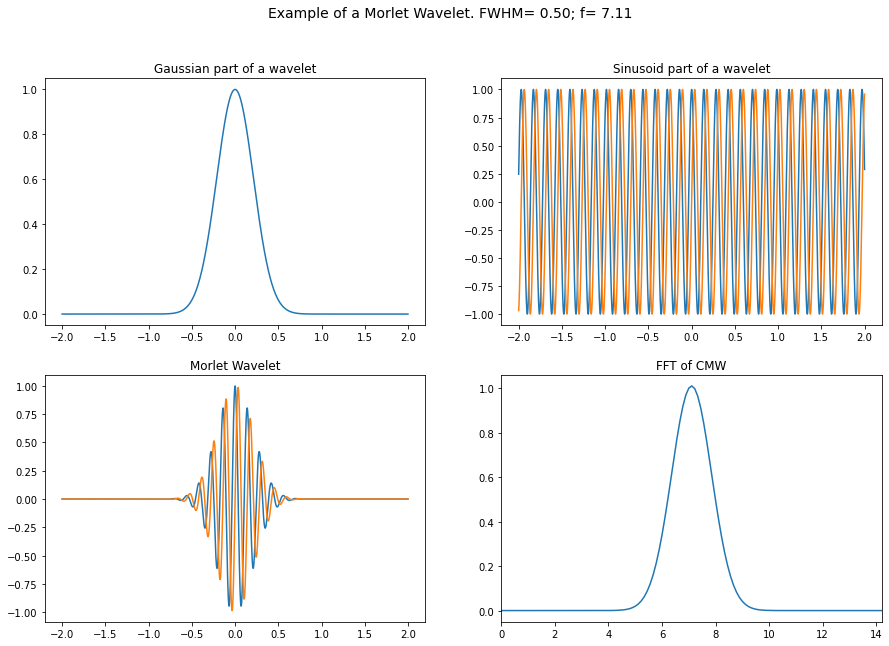

In [7]:
# example
fi = 4
gaus_wav = np.exp(-4*np.log(2)*wavtime**2/fwhms[fi]**2) # gaussian part of a wavelet
sin_wav = np.exp(2*1j*np.pi*wav_frex[fi]*wavtime) #sinusoid part of a wavelet
cmv = gaus_wav*sin_wav # complex merlet wavelet
fft_wav = fft(cmv, n_conv) # FFT of a wavelet
fft_wav = fft_wav / np.max(fft_wav)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(wavtime, gaus_wav)
plt.title('Gaussian part of a wavelet')

plt.subplot(222)
plt.plot(wavtime, sin_wav.real)
plt.plot(wavtime, sin_wav.imag)
plt.title('Sinusoid part of a wavelet')

plt.subplot(223)
plt.plot(wavtime, cmv.real)
plt.plot(wavtime, cmv.imag)
plt.title('Morlet Wavelet')

plt.subplot(224)
plt.plot(hz, np.abs(fft_wav))
plt.xlim([0, wav_frex[fi]*2])
plt.title('FFT of CMW')

plt.suptitle(f"Example of a Morlet Wavelet. FWHM={fwhms[fi]: .2f}; f={wav_frex[fi]: .2f}", fontsize=14)
plt.show()

In [8]:
# Fourier coefficients of signal
fft_signal = fft(signal, n_conv)

In [9]:
tf = np.zeros((len(wav_frex), npnts))

for fi in tqdm(range(len(wav_frex))):
    
    # create time-domain wavelet (use the FWHM formula)
    cmw = np.exp(-4*np.log(2)*wavtime**2/fwhms[fi]**2) * np.exp(2*1j*np.pi*wav_frex[fi]*wavtime)
    
    # compute fourier coefficients of wavelet and normalize
    cmwX = fft(cmw,n_conv)
    
    # second and third steps of convolution
    a = ifft(cmwX*fft_signal / np.max(cmwX), n_conv)
    
    # cut wavelet back to size of data
    a = a[halfwave-1:-halfwave]
    
    # extract power
    tf[fi,:] = np.abs(a)**2

100%|██████████| 20/20 [00:00<00:00, 440.42it/s]


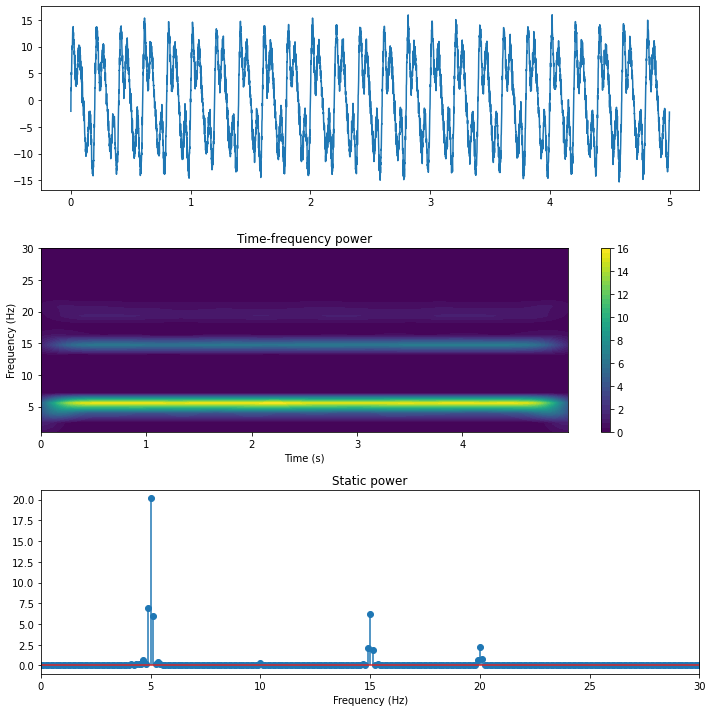

In [10]:
plt.figure(figsize=(10,10))

# plot time-domain signal
plt.subplot(311)
plt.plot(time, signal)

# plot time-frequency plot
plt.subplot(3,1,2)
plt.contourf(time, wav_frex, tf, 50)
# plt.clim([0, .2])
plt.colorbar()
plt.title('Time-frequency power')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

# plot static power spectrum
plt.subplot(3,1,3)
plt.stem(hz, np.abs(fft_signal/npnts)**2, use_line_collection=True)
plt.xlim([0, 30])
plt.title('Static power')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

### Using n Cycles

In [79]:
##### wavelet parameters
# n_cycles = np.linspace(1, 1, 20) 
n_cycles = wav_frex/2
n_cycles

array([ 0.5       ,  1.26315789,  2.02631579,  2.78947368,  3.55263158,
        4.31578947,  5.07894737,  5.84210526,  6.60526316,  7.36842105,
        8.13157895,  8.89473684,  9.65789474, 10.42105263, 11.18421053,
       11.94736842, 12.71052632, 13.47368421, 14.23684211, 15.        ])

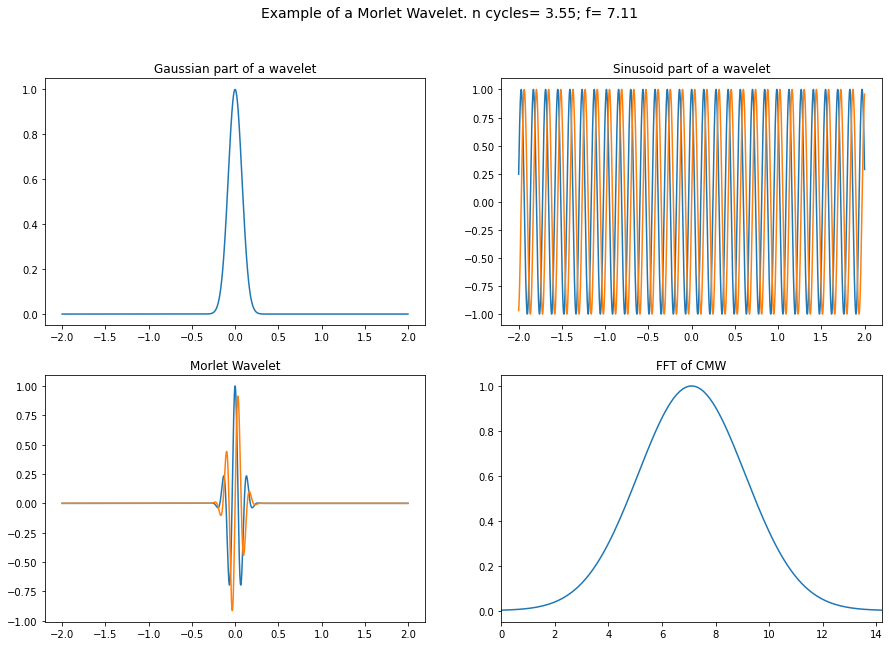

In [80]:
# example
fi = 4
gaus_wav = np.exp(-.5 * wavtime**2 / (n_cycles[fi]/(2*np.pi*wav_frex[fi]))**2) # gaussian part of a wavelet
sin_wav = np.exp(2*1j*np.pi*wav_frex[fi]*wavtime) #sinusoid part of a wavelet
cmv = gaus_wav*sin_wav # complex merlet wavelet
fft_wav = fft(cmv, n_conv) # FFT of a wavelet
fft_wav = fft_wav / np.max(fft_wav)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(wavtime, gaus_wav)
plt.title('Gaussian part of a wavelet')

plt.subplot(222)
plt.plot(wavtime, sin_wav.real)
plt.plot(wavtime, sin_wav.imag)
plt.title('Sinusoid part of a wavelet')

plt.subplot(223)
plt.plot(wavtime, cmv.real)
plt.plot(wavtime, cmv.imag)
plt.title('Morlet Wavelet')

plt.subplot(224)
plt.plot(hz, np.abs(fft_wav))
plt.xlim([0, wav_frex[fi]*2])
plt.title('FFT of CMW')

plt.suptitle(f"Example of a Morlet Wavelet. n cycles={n_cycles[fi]: .2f}; f={wav_frex[fi]: .2f}", fontsize=14)
plt.show()

In [81]:
tf = np.zeros((len(wav_frex), npnts))

for fi in tqdm(range(len(wav_frex))):
    
    # create time-domain wavelet (use the FWHM formula)
    cmw = np.exp(-.5 * wavtime**2 / (n_cycles[fi]/(2*np.pi*wav_frex[fi]))**2) \
    * np.exp(2*1j*np.pi*wav_frex[fi]*wavtime)
    
    # compute fourier coefficients of wavelet and normalize
    cmwX = fft(cmw,n_conv)
    
    # second and third steps of convolution
    a = ifft(cmwX*fft_signal / np.max(cmwX), n_conv)
    
    # cut wavelet back to size of data
    a = a[halfwave-1:-halfwave]
    
    # extract power
    tf[fi,:] = np.abs(a)**2

100%|██████████| 20/20 [00:00<00:00, 345.38it/s]


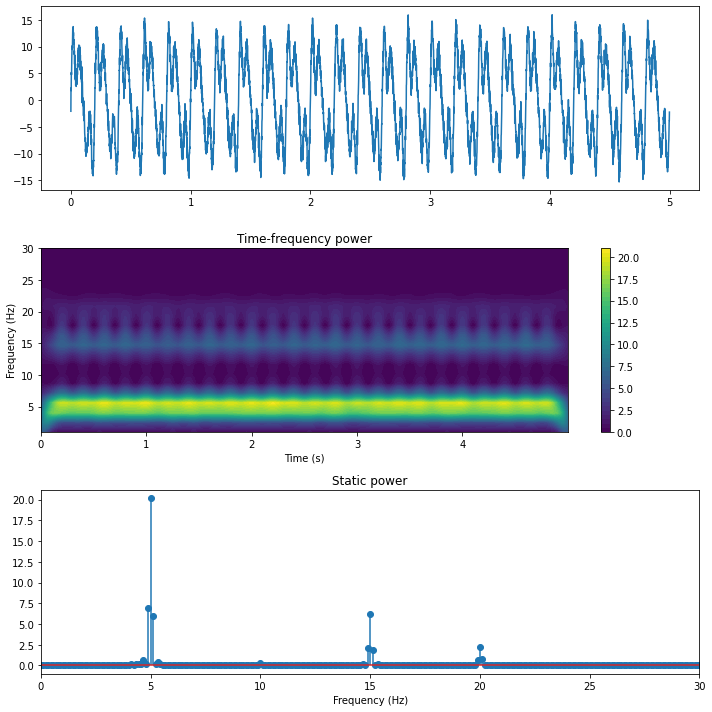

In [78]:
plt.figure(figsize=(10,10))

# plot time-domain signal
plt.subplot(311)
plt.plot(time, signal)

# plot time-frequency plot
plt.subplot(3,1,2)
plt.contourf(time, wav_frex, tf, 50)
# plt.clim([0, .2])
plt.colorbar()
plt.title('Time-frequency power')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

# plot static power spectrum
plt.subplot(3,1,3)
plt.stem(hz, np.abs(fft_signal/npnts)**2, use_line_collection=True)
plt.xlim([0, 30])
plt.title('Static power')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

## `mne` package

In [11]:
ch_names = ['SIM0001']
ch_types = ['grad']
info = create_info(ch_names=ch_names, sfreq=srate, ch_types=ch_types)

In [12]:
epochs = EpochsArray(data=np.reshape(signal, (1, 1, -1)), info=info)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Need more than one channel to make topography for grad. Disabling interactivity.


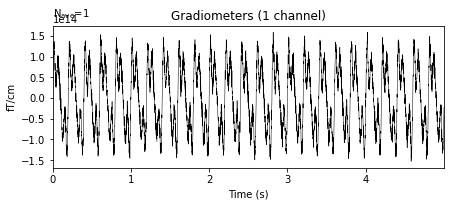

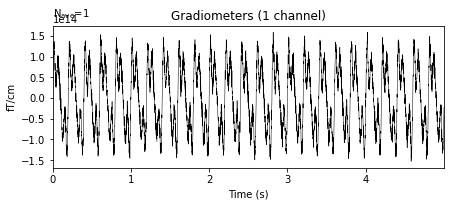

In [13]:
epochs.average().plot()

No baseline correction applied
No baseline correction applied
No baseline correction applied


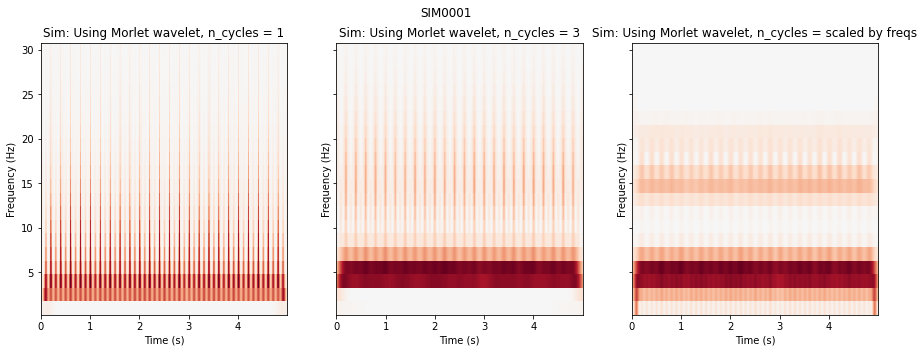

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, wav_frex / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = tfr_morlet(epochs, freqs=wav_frex,
                       n_cycles=n_cycles, return_itc=False)
    power.plot([0], axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Sim: Using Morlet wavelet, n_cycles = %s' % n_cycles)
# plt.tight_layout()